In [1]:
import sys
import json

with open('./paths', 'r') as f:
    globals().update(json.loads(f.read()))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as pltcmap 
import copy
from IPython import display
import IPython
from ipywidgets import interact
%matplotlib inline

In [3]:
import sklearn.preprocessing as skprep
import sklearn.metrics as skmet
import sklearn.model_selection as skmodelselect

In [4]:
sys.path.append(path_Modules_Product_)
sys.path.append(path_Modules_Toolbox_)

In [5]:
import data_processing as myprep
import handles as myhandles
import plots as myplots


ModuleNotFoundError: No module named 'data_processing'

# cutoff 

In [6]:
from sklearn.preprocessing import QuantileTransformer

## dataset_main

In [7]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_main.csv', index_col=0)
cancer_sets = ['Colorectum', 'Lung', 'Breast', 'Ovary', 'Stomach', 'Esophagus']
normal_set = 'Normal'
all_sets = copy.deepcopy(cancer_sets)
all_sets.append(normal_set)
dataset = dataset_.dropna()
dataset = dataset.loc[np.logical_and(dataset.s_Age >= 40, dataset.s_Age <= 70)]
dataset = dataset.loc[np.isin(dataset.s_Tumor, all_sets)].copy()
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

FileNotFoundError: [Errno 2] No such file or directory: '../Data/processed/dataset/ds_main.csv'

In [71]:
p_markers = [x for x in dataset.columns if x.startswith('p_')]


@interact
def fff(p=p_markers):
    print(p)
    transformer = QuantileTransformer(n_quantiles=100)
    dataset['pred'] = transformer.fit_transform(dataset[[p]].values)
    myplots.binroc_multiple(dataset, 'Target', 'pred', 's_Tumor', cancer_sets,
                            'Normal')
    plt.show()

interactive(children=(Dropdown(description='p', options=('p_AFP', 'p_AXL', 'p_ANGIOPOIETIN2', 'p_CA15-3', 'p_C…

## OOB_C

In [142]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_OOB_C.csv', index_col=0)
dataset = dataset_.loc[np.isin(dataset_.s_Tumor, ['Normal', 'Ovarian'])].copy()
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

In [143]:
p_markers = [x for x in dataset.columns if x.startswith('p_')]
# p_markers = [x for x in p_markers if x[-2]!='_']
p_markers = np.sort(p_markers)
plot_rows = np.ceil(len(p_markers) / 2)


@interact
def fff(a=[30, 60, 90, 120, 180, 360, 720, 10000]):
    fig = plt.figure(figsize=(15, 5 * plot_rows))
    for c, p in enumerate(p_markers):
        ax = plt.subplot(plot_rows, 2, c + 1)
        ds = dataset.dropna(subset=[p])
        drop_i = np.logical_and(ds.Target == 1, ds.s_Time2dx > a)
        drop_i = ds.loc[drop_i].index
        ds = ds.drop(drop_i)
        transformer = QuantileTransformer(n_quantiles=100)
        pred = transformer.fit_transform(ds[[p]])
        myplots.binroc(ds.Target, ds[p], title=p)

interactive(children=(Dropdown(description='a', options=(30, 60, 90, 120, 180, 360, 720, 10000), value=30), Ou…

# PCA

In [6]:
from sklearn.decomposition import PCA

## OOB_B

In [64]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_OOB_B.csv', index_col=0)
# marks = [
#     'p_AFP', 'p_CA125','p_CA15-3', 'p_CA19-9', 'p_CEA', 'p_FGF2', 'p_GCSF', 'p_HGF',
#     'p_IL6', 'p_IL8', 'p_MESOTHELIN'
# ]
marks = [x for x in dataset_.columns if x.startswith('p_')]
marks = [x for x in marks if x[-2] != '_']
dataset = dataset_.dropna(subset=marks).copy()
ord_prep = skprep.OrdinalEncoder()
dataset['target'] = ord_prep.fit_transform(dataset[['s_Tumor']]).astype(int)

In [65]:
X = np.log(dataset[marks])
pca = PCA(n_components=2, )
ds = dataset.copy()
res = pca.fit(X).transform(X)
ds['res_x'] = res[:, 0]
ds['res_y'] = res[:, 1]

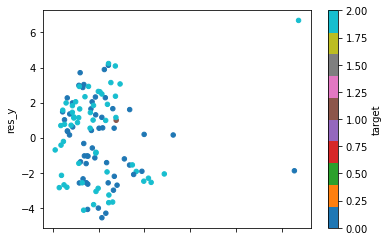

In [66]:
ds.plot.scatter('res_x', 'res_y', c='target', cmap='tab10')

# LDA 

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as skLDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as skQDA

## dataset_main

In [49]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_main.csv', index_col=0)
# cancer_sets = ['Colorectum', 'Lung', 'Breast', 'Ovary', 'Stomach', 'Esophagus']
cancer_sets = ['Colorectum', 'Stomach']
normal_set = 'Normal'
all_sets = copy.deepcopy(cancer_sets)
all_sets.append(normal_set)
dataset = dataset_.dropna()
dataset = dataset.loc[np.logical_and(dataset.s_Age >= 40, dataset.s_Age <= 70)]
dataset = dataset.loc[np.isin(dataset.s_Tumor, all_sets)].copy()
dataset['Target'] = skprep.OrdinalEncoder().fit_transform(dataset[['s_Tumor']])

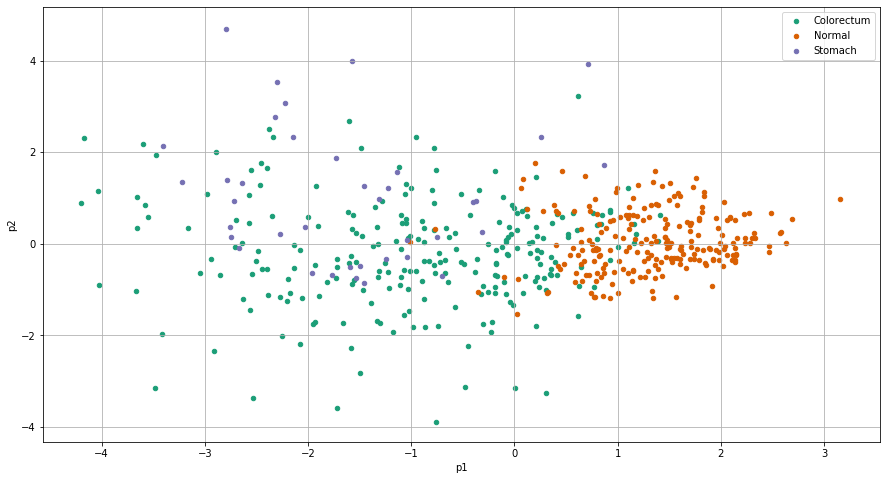

In [83]:
features = [
    'p_AFP',
    'p_HE4',
    'p_CA125',
    'p_IL6',
    'p_IL8',
    'p_PROLACTIN',
    'p_NSE',
    'p_CA15-3',
    'p_CA19-9',
    'p_CEA',
]
targets = 'Target'
X = np.log10(dataset[features])
Y = dataset[targets]
model = skLDA(store_covariance=True,n_components=2)
lda_comp = pd.DataFrame(model.fit_transform(X,Y),columns=['p1','p2'])
lda_comp['cat'] = dataset.s_Tumor.values
plt.figure(figsize=(15,8))
ax = plt.gca()
for c,d in enumerate(lda_comp.groupby('cat')):
    l,d = d
    d.plot.scatter('p1','p2',ax=ax,label=l,color=pltcmap.Dark2(c))
plt.grid()

<Figure size 1080x720 with 0 Axes>

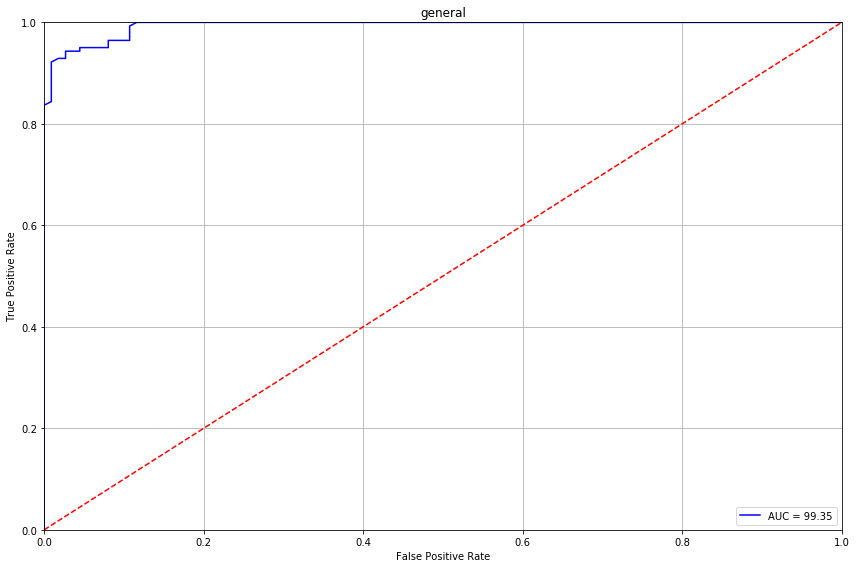

<Figure size 1080x720 with 0 Axes>

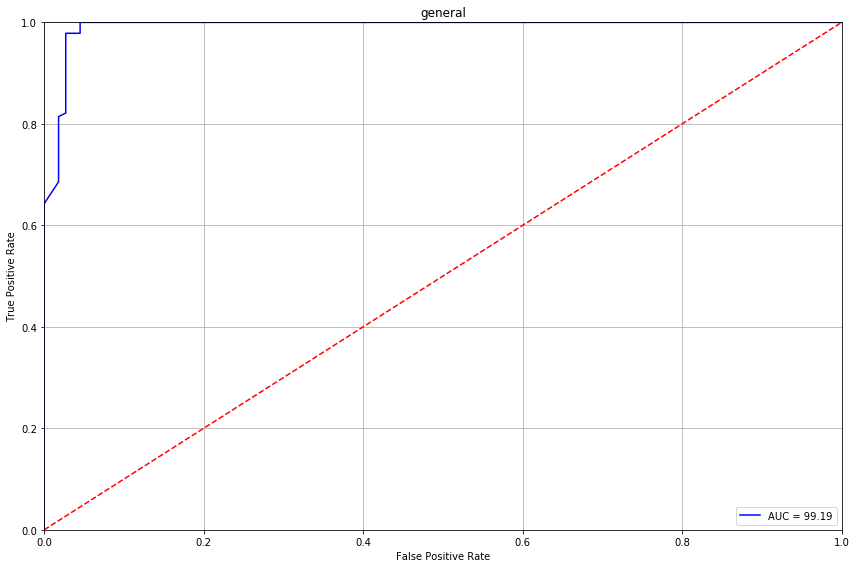

In [20]:
for m, i in zip(models, folds):
    ds = dataset.iloc[i[1]].copy()
    ds['res'] = m.predict_proba(ds[features].values)[:, 1]
    plt.figure(figsize=(15, 10))
    myplots.binroc_multiple(ds, 'Target', 'res', 's_Tumor', cancer_sets,
                            normal_set)
    plt.show()

# -------------------------------
# print('PNAS controls result:')
# res_pnas = Y_pnas_p
# res_pnas = pd.DataFrame(res_pnas, columns=['S1_'])
# res_pnas.plot.kde(grid=True, figsize=(15, 10))
# plt.show()
# res_pnas.describe()
# pnas_bool = np.round(res_pnas['S1_'])
# print('S1_:', pnas_bool.sum(), 'of', len(res_pnas))
# print('error =', pnas_bool.sum()/len(pnas_bool))
# print('log-loss =', -np.log(np.clip(1-res_pnas['S1_'],0.00001,None)).mean())
# res_pnas.describe()

# Decision Tree 

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
import pydotplus

/home/amir/miniconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## dataset_main

In [7]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_main.csv', index_col=0)
# cancer_sets = ['Colorectum', 'Lung', 'Breast', 'Ovary', 'Stomach', 'Esophagus']
cancer_sets = ['Colorectum', 'Stomach']
normal_set = 'Normal'
all_sets = copy.deepcopy(cancer_sets)
all_sets.append(normal_set)
dataset = dataset_.dropna()
dataset = dataset.loc[np.logical_and(dataset.s_Age >= 40, dataset.s_Age <= 70)]
dataset = dataset.loc[np.isin(dataset.s_Tumor, all_sets)].copy()
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

In [8]:
folder = skmodelselect.StratifiedKFold(n_splits=3, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.s_Tumor):
    folds.append([train_index, test_index])

In [13]:
# features = ['p_CEA','p_CA125','p_CA19-9']
features = [
#     'p_AFP',
#     'p_HE4',
#     'p_CA125',
#     'p_IL6',
#     'p_IL8',
#     'p_PROLACTIN',
#     'p_NSE',
#     'p_CA15-3',
#     'p_CA19-9',
#     'p_CEA',
    's_Age','p_CEA','p_CA125'
]
targets = 'Target'
models = []
for train_index, _ in folds:
    X = dataset[features].iloc[train_index].values
    Y = dataset[targets].iloc[train_index].values
    dt = DecisionTreeClassifier(min_samples_leaf=.05)
    dt.fit(X, Y)
    models.append(dt)

<Figure size 1080x720 with 0 Axes>

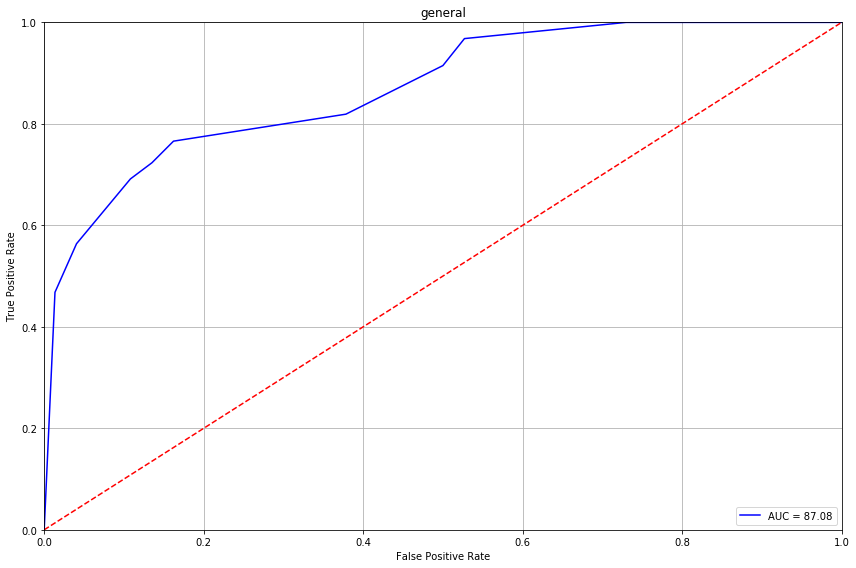

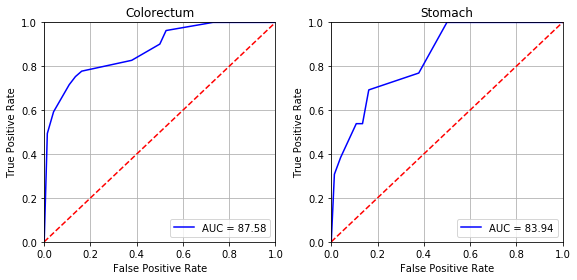

<Figure size 1080x720 with 0 Axes>

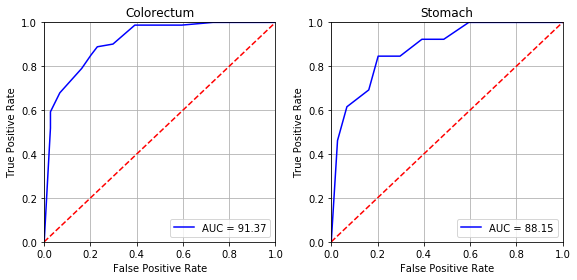

<Figure size 1080x720 with 0 Axes>

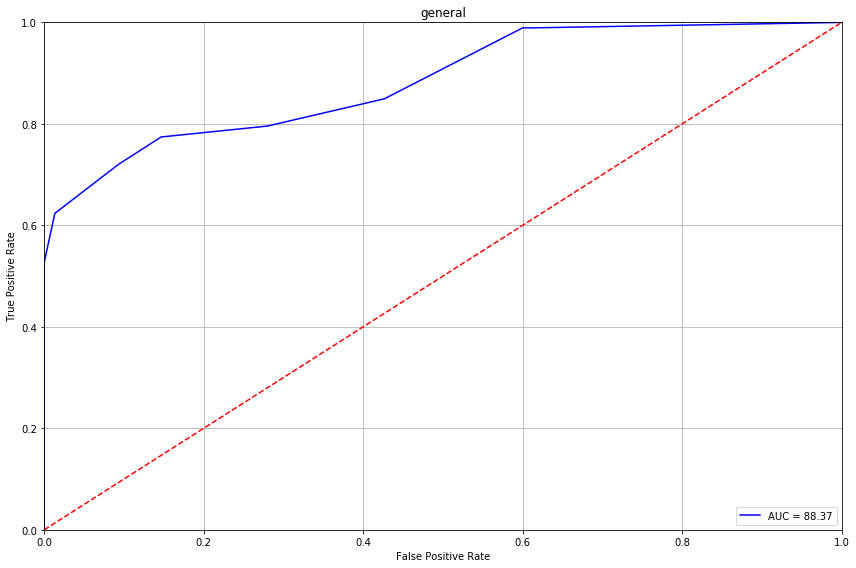

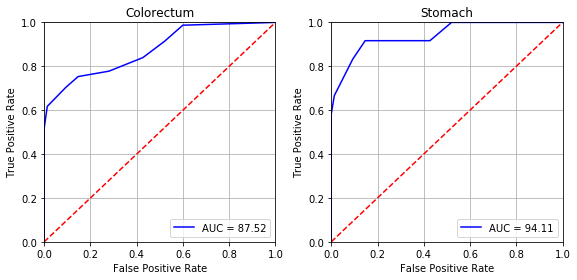

In [14]:
for m, i in zip(models, folds):
    ds = dataset.iloc[i[1]].copy()
    ds['res'] = m.predict_proba(ds[features].values)[:, 1]
    plt.figure(figsize=(15, 10))
    myplots.binroc_multiple(ds, 'Target', 'res', 's_Tumor', cancer_sets,
                            normal_set)
#     plt.show()

# -------------------------------
# print('PNAS controls result:')
# res_pnas = Y_pnas_p
# res_pnas = pd.DataFrame(res_pnas, columns=['S1_'])
# res_pnas.plot.kde(grid=True, figsize=(15, 10))
# plt.show()
# res_pnas.describe()
# pnas_bool = np.round(res_pnas['S1_'])
# print('S1_:', pnas_bool.sum(), 'of', len(res_pnas))
# print('error =', pnas_bool.sum()/len(pnas_bool))
# print('log-loss =', -np.log(np.clip(1-res_pnas['S1_'],0.00001,None)).mean())
# res_pnas.describe()

In [11]:
dot_data = StringIO()
export_graphviz(models[0],
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['Normal', 'Cancer'],
                max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
display.Image(graph.create_png(), retina=True, embed=True, unconfined=True)

## OOB_B

In [18]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_OOB_B.csv', index_col=0)
marks = [
    'p_AFP', 'p_CA125', 'p_CA15-3', 'p_CA19-9', 'p_CEA', 'p_FGF2', 'p_GCSF',
    'p_HGF', 'p_IL6', 'p_IL8', 'p_MESOTHELIN'
]
dataset = dataset_.loc[np.isin(
    dataset_.s_Tumor, ['Breast', 'Normal'])].dropna(subset=marks).copy()
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

In [19]:
folder = skmodelselect.StratifiedKFold(n_splits=2, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.Target):
    folds.append([train_index, test_index])

In [23]:
# features = ['p_CEA','p_CA125','p_CA19-9']
features = marks
targets = 'Target'
models = []
for train_index, _ in folds:
    X = dataset[features].iloc[train_index].values
    X = np.log(X)
    Y = dataset[targets].iloc[train_index].values
    dt = DecisionTreeClassifier(min_samples_leaf=5, class_weight='balanced')
    dt.fit(X, Y)
    models.append(dt)

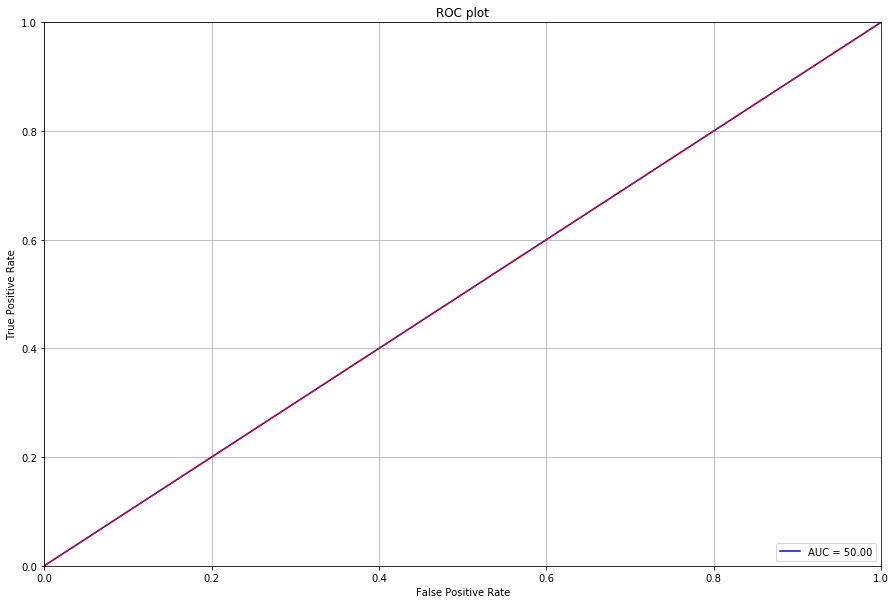

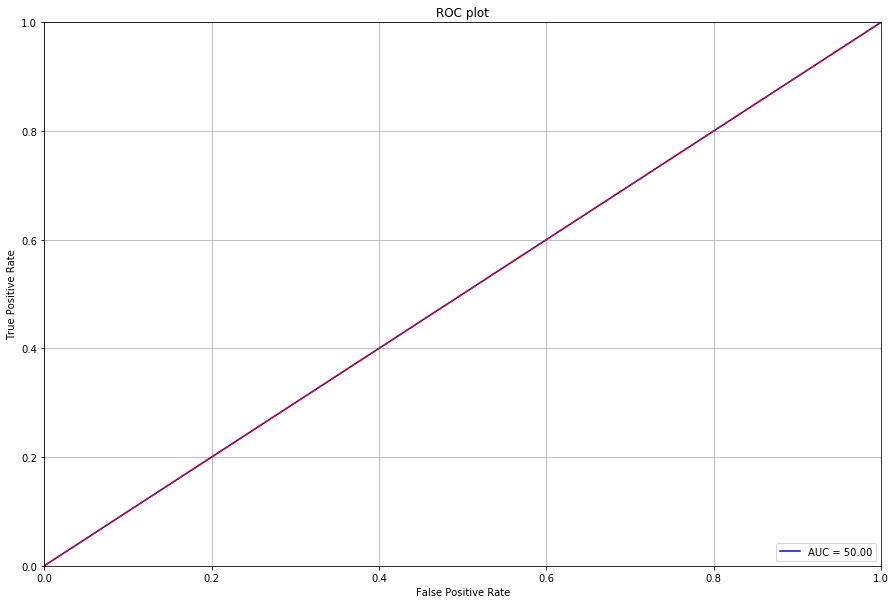

In [24]:
for m, i in zip(models, folds):
    ds = dataset.iloc[i[1]].copy()
    ds['res'] = m.predict_proba(ds[features].values)[:, 1]
    plt.figure(figsize=(15, 10))
    myplots.binroc(ds['Target'], ds['res'])

In [25]:
dot_data = StringIO()
export_graphviz(models[0],
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['Normal', 'Cancer'],
                max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
display.Image(graph.create_png(), retina=True, embed=True, unconfined=True)

## OOB_C

In [7]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_OOB_C.csv', index_col=0)
# marks = [
#     'p_CA125', 'p_CA15-3', 'p_CA19-9', 'p_KLK6', 'p_LEPTIN', 'p_MESOTHELIN',
#     'p_OPN', 'p_PROLACTIN'
# ]
marks = [
 'p_EGFR',
 'p_CA15-3',
 'p_CA19-9',
 'p_CA72-4',
 'p_KLK6',
 'p_OV110',
 'p_OPN',
 'p_CA125',
 'p_PROLACTIN']
dataset = dataset_.dropna(subset=marks)
d1 = dataset.loc[dataset.s_Tumor == 'Normal']
d2 = dataset.loc[dataset.s_Tumor == 'Ovary']
# d2 = d2.loc[d2.s_Time2dx < 180].copy()
dataset = pd.concat((d1, d2))
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

In [8]:
folder = skmodelselect.StratifiedKFold(n_splits=3, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.s_Tumor):
    folds.append([train_index, test_index])

In [9]:
# features = ['p_CEA','p_CA125','p_CA19-9']
features = marks
targets = 'Target'
models = []
for train_index, _ in folds:
    X = dataset[features].iloc[train_index].values
    Y = dataset[targets].iloc[train_index].values
    dt = DecisionTreeClassifier(min_samples_leaf=.05,class_weight='balanced')
    dt.fit(X, Y)
    models.append(dt)

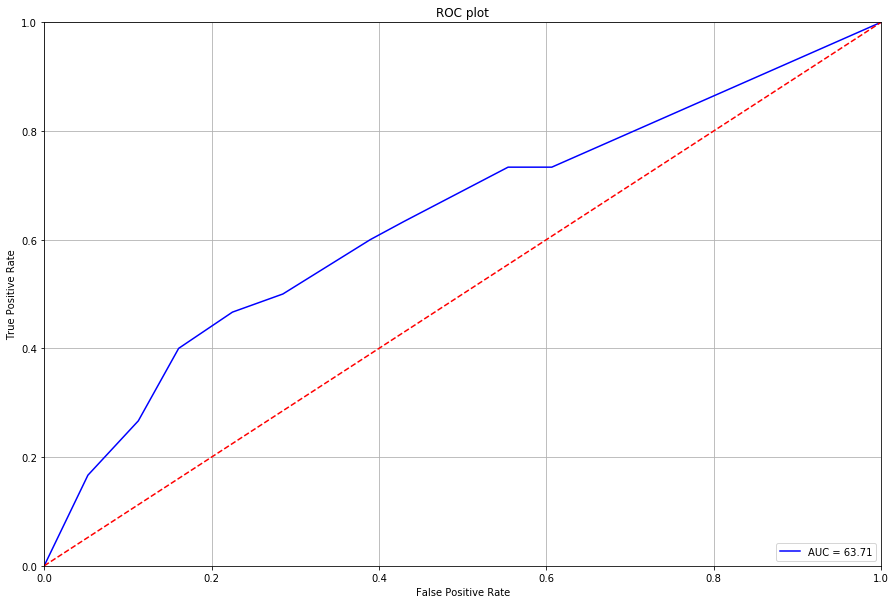

In [10]:
for m, i in zip(models, folds):
    ds = dataset.iloc[i[1]].copy()
    ds['res'] = m.predict_proba(ds[features].values)[:, 1]
    plt.figure(figsize=(15, 10))
    myplots.binroc(ds['Target'], ds['res'])

In [60]:
dot_data = StringIO()
export_graphviz(models[0],
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=features,
                class_names=['Normal', 'Cancer'],
                max_depth=5)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
display.Image(graph.create_png(), retina=True, embed=True, unconfined=True)

# NeuralNet

In [6]:
from sklearn import preprocessing as skprep
import keras
kmodels= keras.models
klayers = keras.layers

Using TensorFlow backend.


## OOB_C

In [20]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_OOB_C.csv', index_col=0)

marks = [
    's_BloodAge', 's_BMI', 'p_HE4_U', 'p_CA125', 'p_CA72-4', 'p_CA15-3',
    'p_CA19-9', 'p_PROLACTIN'
]
dataset = dataset_.dropna(subset=marks)
d1 = dataset.loc[dataset.s_Tumor == 'Normal'].copy()
d2 = dataset.loc[dataset.s_Tumor == 'Ovary'].copy()
d2 = d2.loc[d2.s_Time2dx < 540]
d1.s_Time2dx = -1
dataset = pd.concat((d1, d2))
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0
t2dx_cat = [0, 180, 360]
t2dx_lab = ['healthy'] + [str(int(x / 30)) + 'm'
                          for x in t2dx_cat[1:]] + ['more']
dataset['s_DG'] = np.digitize(dataset.s_Time2dx, t2dx_cat)
dataset['s_Smoker'] = dataset['s_Smoker'].replace(['FALSE', 'Former', 'TRUE'],
                                                  [0, 1, 2])

In [21]:
folder = skmodelselect.StratifiedKFold(n_splits=4, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.s_DG):
    folds.append([train_index, test_index])

In [22]:
def model_gen():
    inp = klayers.Input(shape=(len(marks),))
    l = inp
    l_1 = klayers.Lambda(lambda x:x[:,:2])(l)
    l_2 = klayers.Lambda(lambda x:x[:,2:])(l)
    l_2 = klayers.BatchNormalization()(l_2)
    l_2 = klayers.GaussianNoise(0.2)(l_2)
    l = klayers.Concatenate()([l_1,l_2])
    for _ in range(4):
        l = klayers.Dense(16,kernel_initializer='he_normal')(l)
        l = klayers.BatchNormalization()(l)
        l = klayers.Activation('relu')(l)
    oup = klayers.Dense(1,activation='sigmoid')(l)
    model = kmodels.Model(inputs = inp,outputs = oup)
    model.compile('Adadelta','binary_crossentropy')
    return model

In [23]:
features = marks
targets = 'Target'
X_ds = dataset[features].values
X_ds[:, 2:] = np.log10(X_ds[:, 2:].astype(float))
Y_ds = dataset[targets].values
G_ds = dataset['s_DG'].values
models = []
trans = []
hists = []
c = 0

for train_index, val_index in folds:
    X = X_ds[train_index].copy()
    X_val = X_ds[val_index].copy()
    Y = Y_ds[train_index].copy()
    Y_val = Y_ds[val_index].copy()
    G = G_ds[train_index].copy()
    G1_i = np.where(G==2)[0]
    X = np.delete(X,G1_i,axis=0)
    Y = np.delete(Y,G1_i,axis=0)
    t = skprep.StandardScaler()
    X[:, :] = t.fit_transform(X[:, :])
    #.......
    nn = model_gen()
    h=nn.fit(X, Y,epochs=20,validation_data=(X_val,Y_val))
    hists.append(h)
    #.......
    models.append(nn)
    trans.append(t)
    c += 1

Train on 633 samples, validate on 216 samples
Epoch 1/20
633/633 [==============================] - 1s 2ms/step - loss: 0.8147 - val_loss: 8.7721
Epoch 2/20
633/633 [==============================] - 0s 262us/step - loss: 0.6472 - val_loss: 4.4693
Epoch 3/20
633/633 [==============================] - 0s 254us/step - loss: 0.5364 - val_loss: 1.2349
Epoch 4/20
633/633 [==============================] - 0s 253us/step - loss: 0.4494 - val_loss: 0.3412
Epoch 5/20
633/633 [==============================] - 0s 277us/step - loss: 0.3773 - val_loss: 0.4229
Epoch 6/20
633/633 [==============================] - 0s 245us/step - loss: 0.3194 - val_loss: 0.5497
Epoch 7/20
633/633 [==============================] - 0s 246us/step - loss: 0.2722 - val_loss: 0.7160
Epoch 8/20
633/633 [==============================] - 0s 263us/step - loss: 0.2398 - val_loss: 0.8186
Epoch 9/20
633/633 [==============================] - 0s 251us/step - loss: 0.2294 - val_loss: 0.9393
Epoch 10/20
633/633 [=================

In [24]:
p_ver = np.ceil(len(hists)/2)
plt.figure(figsize=(15,5*p_ver))
for c,h in enumerate(hists):
    plt.subplot(p_ver,2,c+1)
    plt.plot(h.history['loss'],label = 'loss')
    plt.plot(h.history['val_loss'],label = 'val-loss')
    plt.grid()
    plt.legend()

In [25]:
plot_rows = np.ceil(len(models)/2)
fig=plt.figure(figsize=(15,5*plot_rows),dpi=90)
pred_all = np.empty((len(X_ds),2))*np.nan
c=1
for m, i,t in zip(models, folds,trans):
    X = X_ds[i[1]].copy()
    G = G_ds[i[1]].copy()
    X[:,:] = t.transform(X[:,:])
    Y_ = m.predict(X)
    pred_all[i[1],0] = Y_[:,0]
    pred_all[i[1],1] = G
    # ....
    ax=plt.subplot(plot_rows,2,c)
    ds_tmp = pd.DataFrame((Y_[:,0],G)).T
    ds_tmp.columns=['pred','group']
    ds_tmp.boxplot('pred','group',ax=ax)
    plt.title('')
    plt.ylabel('predicted probability')
    plt.xticks(np.arange(len(t2dx_cat)+1)+1,t2dx_lab)
    plt.xlabel('time to dx (months)')
    # hist
    ax = plt.twinx()
    h = ds_tmp['group'].value_counts(normalize=False, sort=False)
    plt.bar(h.index+1, h.values, log=True, alpha=.2)
    plt.ylabel('sapmles count')
    plt.legend(' ')
    c+=1
fig.suptitle('')
#
fig=plt.figure(figsize=(15,8),dpi=90)
ax = plt.gca()
pred_all = pd.DataFrame(pred_all)
pred_all.columns=['pred','group']
pred_all.boxplot('pred','group',ax=ax)
plt.title('')
plt.yticks(np.arange(0,1.01,0.05))
plt.ylabel('predicted probability')
plt.xticks(np.arange(len(t2dx_cat)+1)+1,t2dx_lab)
plt.xlabel('time to dx (months)')
# hist
ax = plt.twinx()
h = pred_all['group'].value_counts(normalize=False, sort=False)
plt.bar(h.index+1, h.values, log=True, alpha=.2)
plt.ylabel('sapmles count')
plt.legend(' ')
fig.suptitle('');

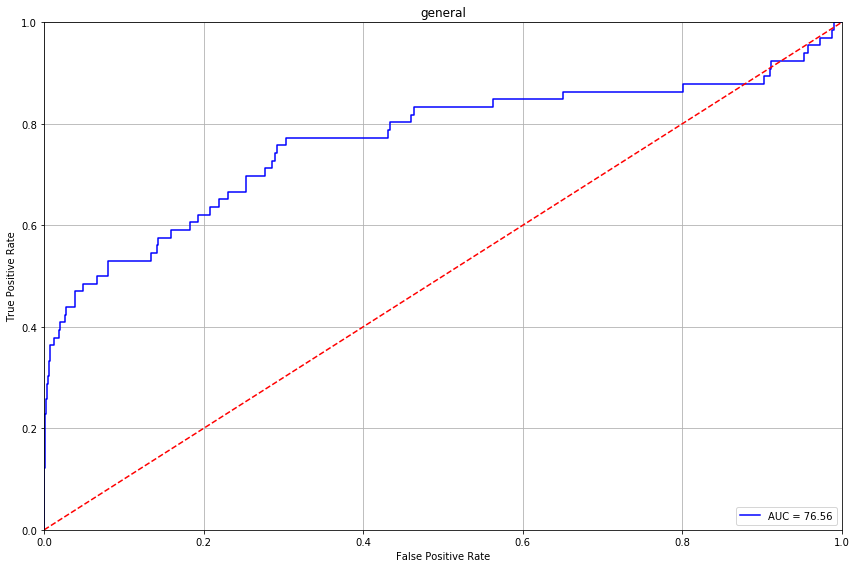

In [26]:
ds_tmp = pred_all.copy()
ds_tmp['target'] = 1
ds_tmp.loc[ds_tmp.group == 0, 'target'] = 0
myplots.binroc_multiple(ds_tmp,'target','pred','group',[1,2,3],0)

# Random Forest 

In [10]:
from sklearn.ensemble import RandomForestClassifier

## dataset_main

In [55]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_main.csv', index_col=0)
# cancer_sets = ['Colorectum', 'Lung', 'Breast', 'Ovary', 'Stomach', 'Esophagus']
cancer_sets = ['Colorectum', 'Stomach','Ovary']
# cancer_sets = ['Ovary']
normal_set = 'Normal'
all_sets = copy.deepcopy(cancer_sets)
all_sets.append(normal_set)
dataset = dataset_.dropna()
dataset = dataset.loc[np.logical_and(dataset.s_Age >= 40, dataset.s_Age <= 70)]
dataset = dataset.loc[np.isin(dataset.s_Tumor, all_sets)].copy()
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

In [56]:
folder = skmodelselect.StratifiedKFold(n_splits=2, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.s_Tumor):
    folds.append([train_index, test_index])

In [57]:
features = [
    'p_AFP',
    'p_HE4',
    'p_CA125',
    'p_IL6',
    'p_IL8',
    'p_PROLACTIN',
    'p_NSE',
    'p_CA15-3',
    'p_CA19-9',
    'p_CEA',
]
targets = 'Target'
models = []
for train_index, _ in folds:
    X = dataset[features].iloc[train_index].values
    Y = dataset[targets].iloc[train_index].values
    rf = RandomForestClassifier(n_estimators=100)
    #     rf = DecisionTreeClassifier()
    rf.fit(X, Y)
    models.append(rf)

<Figure size 1080x720 with 0 Axes>

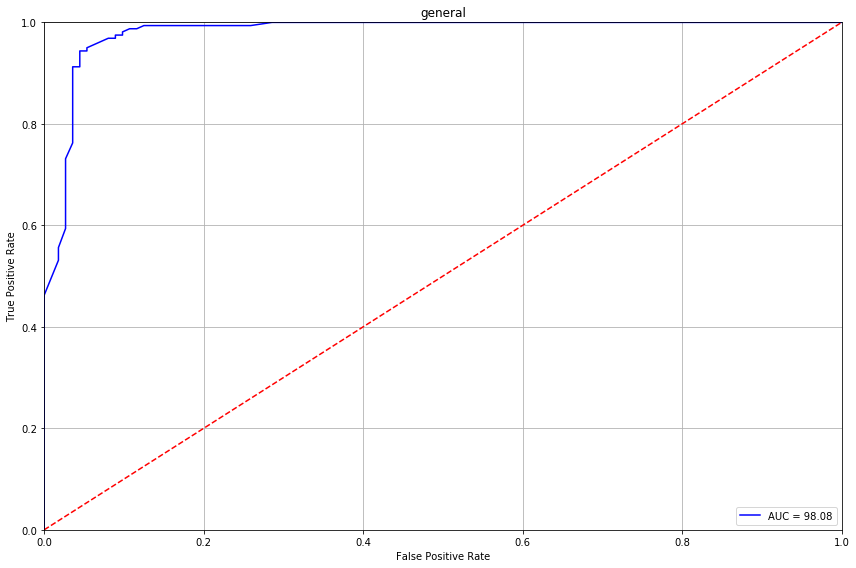

<Figure size 1080x720 with 0 Axes>

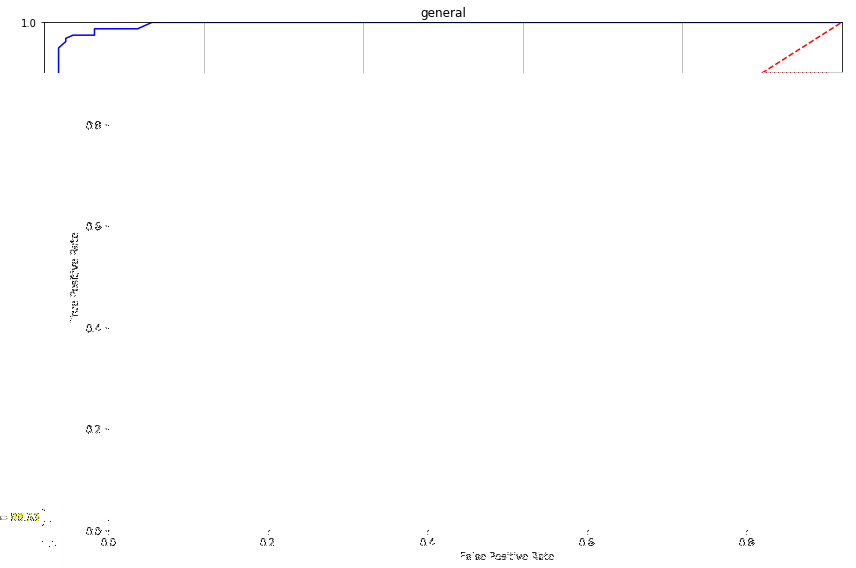

In [58]:
for m, i in zip(models, folds):
    ds = dataset.iloc[i[1]].copy()
    ds['res'] = m.predict_proba(ds[features].values)[:, 1]
    plt.figure(figsize=(15, 10))
    myplots.binroc_multiple(ds, 'Target', 'res', 's_Tumor', cancer_sets,
                            normal_set)
    plt.show()

# -------------------------------
# print('PNAS controls result:')
# res_pnas = Y_pnas_p
# res_pnas = pd.DataFrame(res_pnas, columns=['S1_'])
# res_pnas.plot.kde(grid=True, figsize=(15, 10))
# plt.show()
# res_pnas.describe()
# pnas_bool = np.round(res_pnas['S1_'])
# print('S1_:', pnas_bool.sum(), 'of', len(res_pnas))
# print('error =', pnas_bool.sum()/len(pnas_bool))
# print('log-loss =', -np.log(np.clip(1-res_pnas['S1_'],0.00001,None)).mean())
# res_pnas.describe()

## OOB_A

In [158]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_OOB_A.csv', index_col=0)
marks = [
    'p_CA125',
    'p_CA19-9',
    'p_CEA',
    'p_HE4',
    'p_NSE',
    'p_OPG',
]
dataset = dataset_.dropna(subset=marks).copy()
dataset = dataset.dropna(subset=['s_Tumor'])
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

In [159]:
folder = skmodelselect.StratifiedKFold(n_splits=2, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.s_Tumor):
    folds.append([train_index, test_index])

In [160]:
features = marks
targets = 'Target'
models = []
for train_index, _ in folds:
    X = dataset[features].iloc[train_index].values
    Y = dataset[targets].iloc[train_index].values
    dt = RandomForestClassifier(min_samples_leaf=.05,
                                class_weight='balanced',
                                n_estimators=20)
    dt.fit(X, Y)
    models.append(dt)

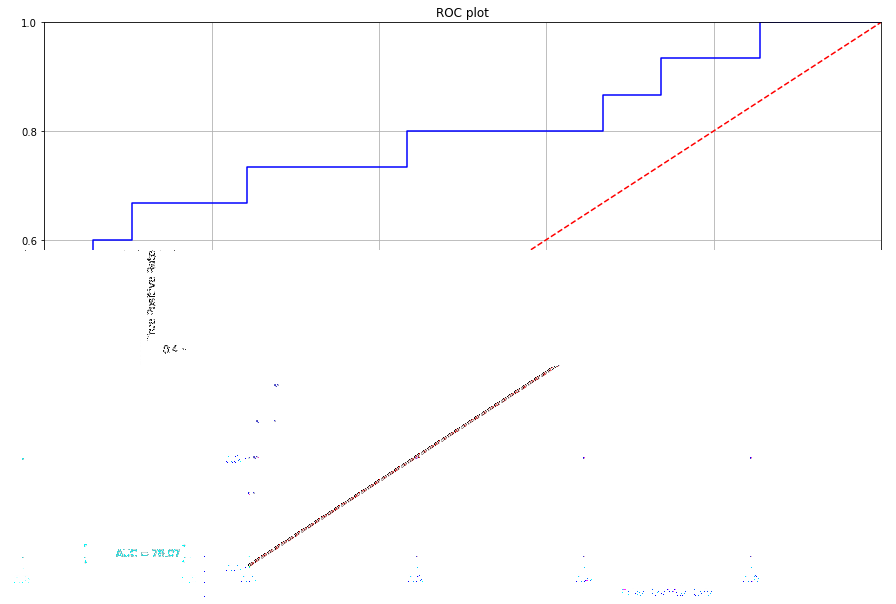

In [161]:
for m, i in zip(models, folds):
    ds = dataset.iloc[i[1]].copy()
    i_drop = ds.loc[ds.Target == 1]
    i_drop = i_drop.loc[i_drop.s_Time2dx > 180].index
    ds = ds.drop(i_drop)
    ds['res'] = m.predict_proba(ds[features].values)[:, 1]
    plt.figure(figsize=(15, 10))
    myplots.binroc(ds['Target'], ds['res'])

## OOB_B

In [154]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_OOB_B.csv', index_col=0)
marks = [
    's_Age', 'p_AFP', 'p_CA125', 'p_CA15-3', 'p_CA19-9', 'p_CEA', 'p_FGF2',
    'p_GCSF', 'p_HGF', 'p_IL6', 'p_IL8', 'p_MESOTHELIN'
]
dataset = dataset_.loc[np.isin(
    dataset_.s_Tumor, ['Breast', 'Normal'])].dropna(subset=marks).copy()
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

In [155]:
folder = skmodelselect.StratifiedKFold(n_splits=2, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.Target):
    folds.append([train_index, test_index])

In [156]:
# features = ['p_CEA','p_CA125','p_CA19-9']
features = marks
targets = 'Target'
models = []
for train_index, _ in folds:
    X = dataset[features].iloc[train_index].values
    X = np.log(X)
    Y = dataset[targets].iloc[train_index].values
    dt = RandomForestClassifier(min_samples_leaf=5,
                                class_weight='balanced',
                                n_estimators=30)
    dt.fit(X, Y)
    models.append(dt)

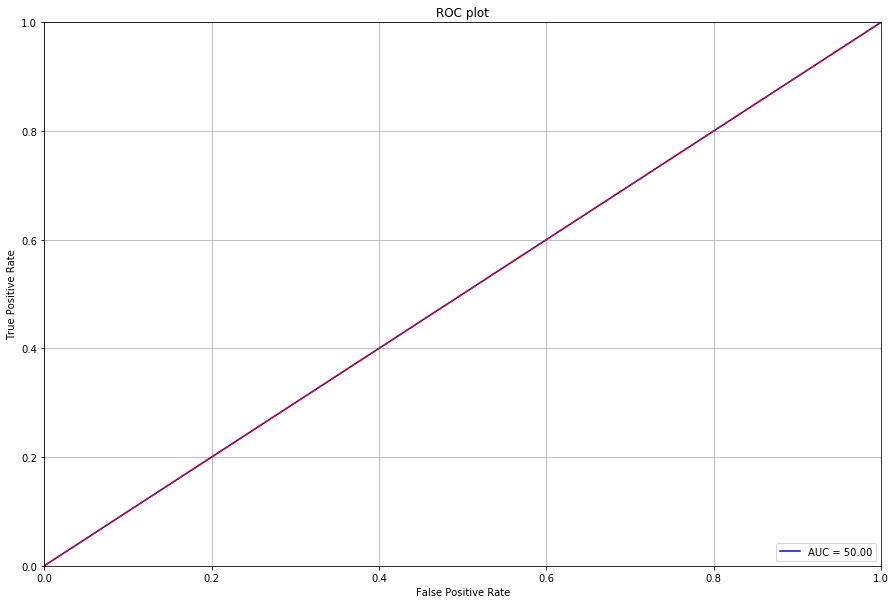

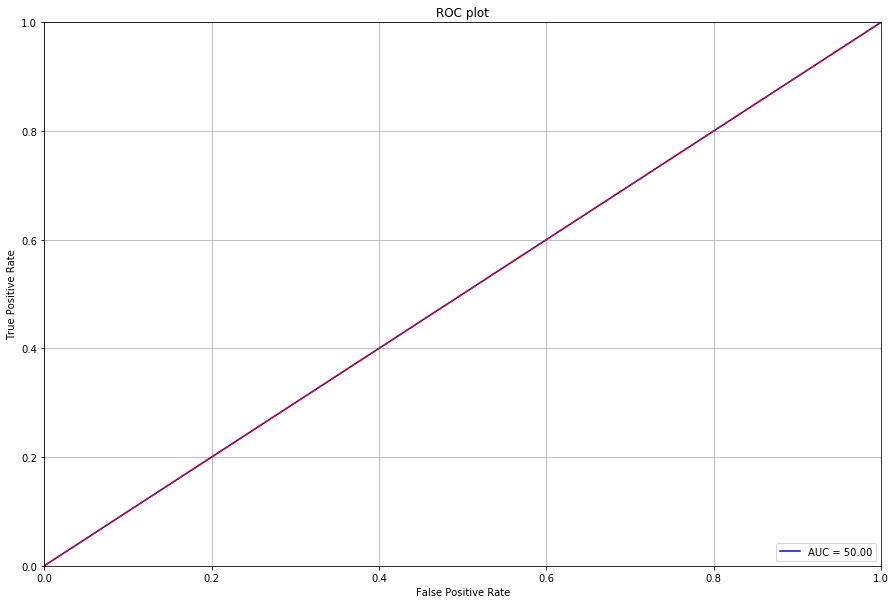

In [157]:
for m, i in zip(models, folds):
    ds = dataset.iloc[i[1]].copy()
    ds['res'] = m.predict_proba(ds[features].values)[:, 1]
    plt.figure(figsize=(15, 10))
    myplots.binroc(ds['Target'], ds['res'])

## OOB_C

In [89]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_OOB_C.csv', index_col=0)
# marks = ['p_CA125', 'p_CA15-3', 'p_CA19-9', 'p_PROLACTIN','p_HE4_U']
# marks = [
#  'p_MESOTHELIN',
#  'p_MMP7',
#  'p_IGFBP2',
#  'p_SPONDIN',
#  'p_SLPI',
#  'p_HEPC',
#  'p_ITIH4',
#  'p_CTAP',
#  'p_TT',
#  'p_TRF',
#  'p_B2M',
#  'p_APO',
#  'p_EOTAXIN',
#  'p_MMP3',
#  'p_SVCAM',
#  'p_EGFR',
#  'p_CA15-3',
#  'p_CA19-9',
#  'p_CA72-4',
#  'p_KLK6',
#  'p_OV110',
#  'p_LEPTIN',
#  'p_OPN',
#  'p_IGF2',
#  'p_MIF',
#  'p_CA125',
#  'p_PROLACTIN']
marks = [
 'p_EGFR',
 'p_CA15-3',
 'p_CA19-9',
 'p_CA72-4',
 'p_KLK6',
 'p_OV110',
 'p_OPN',
 'p_CA125',
 'p_PROLACTIN']
dataset = dataset_.dropna(subset=marks).copy()
dataset = dataset.loc[np.isin(dataset.s_Tumor,['Normal','Ovary'])]
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

In [95]:
folder = skmodelselect.StratifiedKFold(n_splits=2, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.Target):
    folds.append([train_index, test_index])

In [103]:
features = marks
targets = 'Target'
models = []
for train_index, _ in folds:
    X = dataset[features].iloc[train_index].values
    Y = dataset[targets].iloc[train_index].values
    dt = RandomForestClassifier(
                                class_weight='balanced',
                                max_depth=5,min_samples_split=.5,
                                n_estimators=100)
    dt.fit(X, Y)
    models.append(dt)

In [105]:
@interact
def fff(l=[0, 30, 60, 90, 180, 360],h=[30, 60, 90, 180, 360,np.inf]):
    for m, i in zip(models, folds):
        ds = dataset.iloc[i[1]].copy()
        i_drop = ds.loc[ds.Target == 1]
        i_drop = i_drop.loc[np.logical_or(i_drop.s_Time2dx < l,i_drop.s_Time2dx >h)].index
        ds = ds.drop(i_drop)
        ds['res'] = m.predict_proba(ds[features].values)[:, 1]
        plt.figure(figsize=(15, 10))
        myplots.binroc(ds['Target'], ds['res'])

interactive(children=(Dropdown(description='l', options=(0, 30, 60, 90, 180, 360), value=0), Dropdown(descript…

# GP

In [13]:
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as gpkern

## dataset_main

In [11]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_main.csv', index_col=0)
cancer_sets = ['Colorectum', 'Lung', 'Breast', 'Ovary', 'Stomach']
normal_set = 'Normal'
all_sets = copy.deepcopy(cancer_sets)
all_sets.append(normal_set)
dataset = dataset_.dropna()
dataset = dataset.loc[np.logical_and(dataset.s_Age >= 40, dataset.s_Age <= 70)]
dataset = dataset.loc[np.isin(dataset.s_Tumor, all_sets)].copy()
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0

In [12]:
folder = skmodelselect.StratifiedKFold(n_splits=4, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.s_Tumor):
    folds.append([train_index, test_index])

In [14]:
features = [
    'p_HE4',
    'p_CA125'
]
targets = 'Target'
models = []
for train_index, _ in folds:
    X = dataset[features].iloc[train_index].values
    Y = dataset[targets].iloc[train_index].values
    gp = GaussianProcessClassifier(n_restarts_optimizer=10,n_jobs=-1)
    gp.fit(X, Y)
    models.append(gp)

In [52]:
for m, i in zip(models, folds):
    ds = dataset.iloc[i[1]].copy()
    ds['res'] = m.predict_proba(ds[features].values)[:, 1]
    plt.figure(figsize=(15, 10))
    myplots.binroc_multiple(ds, 'Target', 'res', 's_Tumor', cancer_sets,
                            normal_set)
    plt.show()

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

<Figure size 1080x720 with 0 Axes>

## OOB_C

In [14]:
dataset_ = pd.read_csv('../Data/processed/dataset/ds_OOB_C.csv', index_col=0)

marks = [
    's_BloodAge', 's_BMI', 'p_HE4_U', 'p_CA125', 'p_CA72-4', 'p_CA15-3',
    'p_CA19-9', 'p_PROLACTIN'
]
dataset = dataset_.dropna(subset=marks)
d1 = dataset.loc[dataset.s_Tumor == 'Normal'].copy()
d2 = dataset.loc[dataset.s_Tumor == 'Ovary'].copy()
d2 = d2.loc[d2.s_Time2dx < 540]
d1.s_Time2dx = -1
dataset = pd.concat((d1, d2))
dataset['Target'] = 1
dataset.loc[dataset.s_Tumor == 'Normal', 'Target'] = 0
t2dx_cat = [0, 180, 360]
t2dx_lab = ['healthy'] + [str(int(x / 30)) + 'm'
                          for x in t2dx_cat[1:]] + ['more']
dataset['s_DG'] = np.digitize(dataset.s_Time2dx, t2dx_cat)
dataset['s_Smoker'] = dataset['s_Smoker'].replace(['FALSE', 'Former', 'TRUE'],
                                                  [0, 1, 2])

In [15]:
folder = skmodelselect.StratifiedKFold(n_splits=4, shuffle=True)
folds = []
for train_index, test_index in folder.split(dataset.index, dataset.s_DG):
    folds.append([train_index, test_index])

In [16]:
features = marks
targets = 'Target'
X_ds = dataset[features].values
X_ds[:, 2:] = np.log10(X_ds[:, 2:].astype(float))
Y_ds = dataset[targets].values
G_ds = dataset['s_DG'].values
models = []
trans = []
c = 0

for train_index, val_index in folds:
    X = X_ds[train_index].copy()
    Y = Y_ds[train_index].copy()
    G = G_ds[train_index].copy()
    G1_i = np.where(G==2)[0]
    X = np.delete(X,G1_i,axis=0)
    Y = np.delete(Y,G1_i,axis=0)
    t = skprep.StandardScaler()
    X[:, :] = t.fit_transform(X[:, :])
    #.......
    kern = 1.0 * gpkern.RBF(length_scale_bounds=(1e-05, 10))  + 1.0*gpkern.WhiteKernel()
    gp = GaussianProcessClassifier(kern, n_restarts_optimizer=2, n_jobs=-1)
    gp.fit(X, Y)
    #.......
    models.append(gp)
    trans.append(t)
    print(c, ':\n\t', gp.kernel_,'\n\tlmll = ',gp.log_marginal_likelihood_value_)
    c += 1

0 :
	 3.1**2 * RBF(length_scale=5.01) + 0.00316**2 * WhiteKernel(noise_level=1e-05) 
	lmll =  -98.02369488676912
1 :
	 3.05**2 * RBF(length_scale=4.48) + 0.00316**2 * WhiteKernel(noise_level=1e-05) 
	lmll =  -90.61728205441082
2 :
	 2.56**2 * RBF(length_scale=4.37) + 0.00316**2 * WhiteKernel(noise_level=1e-05) 
	lmll =  -101.40755233968285
3 :
	 2.85**2 * RBF(length_scale=4.18) + 0.0196**2 * WhiteKernel(noise_level=0.000385) 
	lmll =  -96.38351101414698


In [18]:
plot_rows = np.ceil(len(models)/2)
fig=plt.figure(figsize=(15,5*plot_rows),dpi=90)
pred_all = np.empty((len(X_ds),2))*np.nan
c=1
for m, i,t in zip(models, folds,trans):
    X = X_ds[i[1]].copy()
    G = G_ds[i[1]].copy()
    X[:,:] = t.transform(X[:,:])
    Y_ = m.predict_proba(X)
    pred_all[i[1],0] = Y_[:,1]
    pred_all[i[1],1] = G
    # ....
    ax=plt.subplot(plot_rows,2,c)
    ds_tmp = pd.DataFrame((Y_[:,1],G)).T
    ds_tmp.columns=['pred','group']
    ds_tmp.boxplot('pred','group',ax=ax)
    plt.title('')
    plt.ylabel('predicted probability')
    plt.xticks(np.arange(len(t2dx_cat)+1)+1,t2dx_lab)
    plt.xlabel('time to dx (months)')
    # hist
    ax = plt.twinx()
    h = ds_tmp['group'].value_counts(normalize=False, sort=False)
    plt.bar(h.index+1, h.values, log=True, alpha=.2)
    plt.ylabel('sapmles count')
    plt.legend(' ')
    c+=1
fig.suptitle('')
#
fig=plt.figure(figsize=(15,8),dpi=90)
ax = plt.gca()
pred_all = pd.DataFrame(pred_all)
pred_all.columns=['pred','group']
pred_all.boxplot('pred','group',ax=ax)
plt.title('')
plt.yticks(np.arange(0,1.01,0.05))
plt.ylabel('predicted probability')
plt.xticks(np.arange(len(t2dx_cat)+1)+1,t2dx_lab)
plt.xlabel('time to dx (months)')
# hist
ax = plt.twinx()
h = pred_all['group'].value_counts(normalize=False, sort=False)
plt.bar(h.index+1, h.values, log=True, alpha=.2)
plt.ylabel('sapmles count')
plt.legend(' ')
fig.suptitle('');

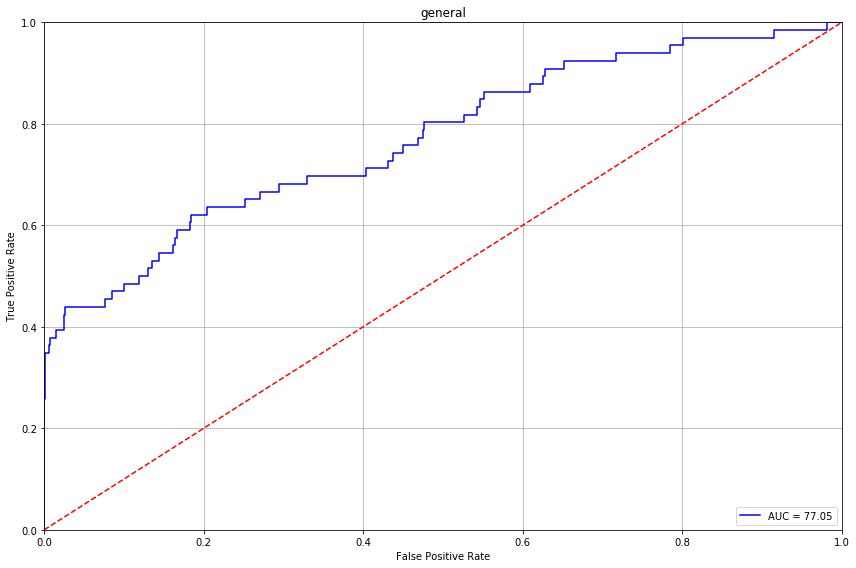

In [19]:
ds_tmp = pred_all.copy()
ds_tmp['target'] = 1
ds_tmp.loc[ds_tmp.group == 0, 'target'] = 0
myplots.binroc_multiple(ds_tmp,'target','pred','group',[1,2,3],0)